In [1]:
pip install -U scikit-learn statsmodels Kaggle opencv-python tensorflow sklearn.ensemble sklearn.utils

  Using cached statsmodels-0.13.2-cp39-cp39-win_amd64.whl (9.1 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sklearn.ensemble (from versions: none)
ERROR: No matching distribution found for sklearn.ensemble


In [2]:
import numpy as np
from numpy import argmax
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import pickle
from pickle import dump
from statsmodels.tools import categorical
from skimage.filters import prewitt_h,prewitt_v
from sklearn.neighbors import KNeighborsClassifier
from keras.models import load_model

import zipfile
from PIL import Image
from sklearn.metrics import plot_confusion_matrix, multilabel_confusion_matrix, roc_auc_score,accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import time


FishCategories = ["Black Sea Sprat", "Gilt-Head Bream", "Hourse Mackerel", "Red Mullet", "Red Sea Bream", "Sea Bass", "Shrimp","Striped Red Mullet", "Trout"]

In [3]:
#{"username":"dashdg7","key":"8d15678f2d374d39b3fd6764ec02ec4d"}
# Gets the Fish Dataset from kaggle and downloads it to the working directory
def DownloadDataset():
    os.environ['KAGGLE_USERNAME'] = 'dashdg7'
    os.environ['KAGGLE_KEY'] = '8d15678f2d374d39b3fd6764ec02ec4d'
    api = KaggleApi()
    print("Authenticating API")
    api.authenticate()
    print("Downloading Dataset to Working Directory")
    print("This could take a few minutes.")
    api.dataset_download_file("crowww/a-large-scale-fish-dataset", file_name = '')
    with zipfile.ZipFile(os.path.join(os.getcwd (),'archive.zip'), 'r') as zipref:
        for file in zipref.namelist():
            if file.startswith('Fish_Dataset/Fish_Dataset'):
                archive.extract(file, os.getcwd())
    print("Download Complete")

#Runs through the zip folder and extracts on the images   
def GetData ():
    RawColor = []
    RawBW = []
    ImageLabel = []
    FishPosition = []
    counter = 0
    print("Getting Images")
    with zipfile.ZipFile(os.path.join(os.getcwd(),'archive.zip'), 'r') as zipref:
        for imagepath in zipref.namelist():
            if (imagepath.__contains__('GT')):
                pass
            elif (imagepath.__contains__('NA_Fish_Dataset')):
                pass
            elif (imagepath.__contains__('png')): #Text was img
                for FishType in FishCategories:
                    if imagepath.__contains__(FishType):
                        fishcategory = FishType
                        FishNumber = FishCategories.index(FishType)
                OriginalImage = Image.open(zipref.open(imagepath))
                OriginalImagePixelBGR = np.array(OriginalImage)
                ImageLabel.append(fishcategory)
                FishPosition.append(FishNumber)
                RawBW.append(cv2.cvtColor(OriginalImagePixelBGR, cv2.COLOR_BGR2GRAY))
               # ResizedImage = Resize(OriginalImagePixelBGR,75,75)
               # ResizedImagePixelBGR = np.array(ResizedImage)
                RawColor.append(OriginalImagePixelBGR)    
                if (counter + 1) % 500==0:
                    print("Retrieved",counter + 1,"Images of 9000")
                elif counter == 0:
                    print("Retrieved",counter,"Images of 9000")
                counter = counter + 1
    return np.array(RawColor), np.array(ImageLabel),np.array(RawBW), np.array(FishPosition)

#simple function for resizing images
def Resize(image_,w,h):
    newsize = (w, h)
    return cv2.resize(image_, dsize = newsize)

# Shuffles the position of an array
def Shuffle(array):
    return random.shuffle(array)

# Gets a random sampling
def RandomSample(SampleAmount):
    ListRange = range(9000)
    Sample = []
    for i in range(SampleAmount):
        Sample.append(random.choice(ListRange))
    return Sample

# Gets the average color value of an image of a given color
def GetColorAverage(ColorNumber):
    col = []
    for c in range(len(ColorImages)):
        ca = np.mean(ColorImages[c][:,:,ColorNumber])
        col.append(ca)
    return np.array(col)

# Gets the average color value of an image at a given percentile for a given color
def GetColorQ(ColorNumber,pct):
    col = []
    for c in range(len(ColorImages)):
        ca = np.array(ColorImages[c][:,:,ColorNumber])
        q = np.percentile(ca, pct)
        col.append(q)
    return np.array(col)

#Saves models to the working directory
def SaveFile(Model,FileName):
    Model.save(FileName) 
    print("Saved model to disk")
 
 #Opens a model from the working directory
def OpenFile(FileName):
    return load_model(FileName)

# builds the fitted CNN model
def BuildCNN(ResizeH, ResizeW, BatchSize, Epochs, X, Y,ArrayDepth):
    #GET IMAGE LABELS
    encoder = OneHotEncoder(sparse=False)
    Y_VALUE = pd.DataFrame(Y)
    Y_VALUE = Y_VALUE.astype('category')
    Y_VALUE_CAT = pd.DataFrame(encoder.fit_transform(Y_VALUE)) 
    
    #RESIZE AND ADD BLUR TO IMAGES
    ResizedImages = []
    for i in range(len(X)):
        R_images = Resize(X[i],ResizeH,ResizeW)
        ResizedImages.append(R_images)
    ResizedImages = np.array(ResizedImages)
    
    #TRAIN TEST SPLIT
    X_train, X_test, y_train, y_test = train_test_split(ResizedImages, Y_VALUE_CAT, test_size=0.33, random_state=42)
    y_test_array = argmax(np.array(y_test), axis=-1).astype('int')
    y_train_array = argmax(np.array(y_train), axis=-1).astype('int')
    
    #CONSTRUCT LAYERS MODEL
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(ResizeH, ResizeW, ArrayDepth)))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())

    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(9, activation = "softmax"))
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    #TRAIN MODEL
    model.fit(X_train, y_train, batch_size = BatchSize, epochs = Epochs)
    
    return model, X_test, y_test_array, X_train, y_train_array


#Applies a filtering across the image to remove black and blue color pixels
def ColorFilters(fishImage):
    RedF = (fishImage[:,:,0] > 100)
    InvBlueF = (fishImage[:,:,2] < 115)
    WhiteF = ((fishImage[:,:,0] > 180) & (fishImage[:,:,1] > 180) & (fishImage[:,:,2] > 130))
    BlackF = ((fishImage[:,:,0] < 25) & (fishImage[:,:,1] < 25) & (fishImage[:,:,2] < 25))
    GrayF = (fishImage[:,:,0] < 140) & (fishImage[:,:,1] < 140) & (fishImage[:,:,2] < 140) & (fishImage[:,:,0] > 100) & (fishImage[:,:,1] > 100) & (fishImage[:,:,2] > 100)
    DGrayF = (fishImage[:,:,0] < 100) & (fishImage[:,:,1] < 100) & (fishImage[:,:,2] < 100) & (fishImage[:,:,0] > 80) & (fishImage[:,:,1] > 80) & (fishImage[:,:,2] > 80)
    Filter = (RedF*InvBlueF) + (GrayF + DGrayF + WhiteF + BlackF)

    FilteredImage = fishImage.copy()
    FilteredImage[:, :, 0] = FilteredImage[:, :, 0] * Filter
    FilteredImage[:, :, 1] = FilteredImage[:, :, 1] * Filter
    FilteredImage[:, :, 2] = FilteredImage[:, :, 2] * Filter
    return FilteredImage

#Using the colors below each pixel in every image is classified as one of those colors. From there
#the pixels that are black and blue  are removed from the image and the rest of the colors are 
#counted and totaled so they can be used in the KNN, SVM, and RF
def ClassifyPixelColor(Image):
    Red = [200,75,75]
    Orange = [200,125,75]
    Brown = [151,122,83]
    Tan = [217,171,118] 
    Blue = [75,75,200]
    LightBlue = [165,165,165]
    #DGray = [80,80,80]
    Gray = [125,125,125]
    White = [235,235,235]
    Black = [20,20,20]
    
    NewImage = np.empty((Image.shape))
    PixelColorValues = [Red,Orange,Brown,Tan,Blue,LightBlue,Gray,White,Black]
    PixelColorList = ["Red","Orange","Brown","Tan","Blue","LightBlue","Gray","White","Black"]
    row,column,depth = Image.shape
    Reds = 0
    Oranges = 0
    Browns = 0
    Tans = 0
    Blues = 0
    LightBlues = 0
    DGrays = 0
    Grays = 0
    Whites = 0
    Blacks = 0    
    for r in range(row):
        for c in range(column):
            Difference = 0
            for Cl in range(len(PixelColorList)):
                RedDif = abs(Image[r][c][0] - PixelColorValues[Cl][0])
                GreenDif = abs(Image[r][c][1] - PixelColorValues[Cl][1])
                BlueDif = abs(Image[r][c][2] - PixelColorValues[Cl][2])
                TempDifference = (RedDif + GreenDif + BlueDif)
                if Difference == 0:
                    CurrentClassification = PixelColorList[Cl]
                    Difference = TempDifference
                elif Difference > TempDifference:
                    CurrentClassification = PixelColorList[Cl]
                    Difference = TempDifference
            if CurrentClassification == "Red":
                Reds = Reds + 1
                PixelValue = Red
            elif CurrentClassification == "Orange":
                Oranges = Oranges + 1
                PixelValue = Orange
            elif CurrentClassification == "Brown":
                Browns = Browns + 1
                PixelValue = Brown
            elif CurrentClassification == "Tan":
                Tans = Tans + 1
                PixelValue = Tan
            elif CurrentClassification == "Blue":
                Blues = Blues + 1
                PixelValue = Black
            elif CurrentClassification == "LightBlue":
                LightBlues = LightBlues + 1
                PixelValue = Black
            elif CurrentClassification == "DGray":
                DGrays = DGrays + 1
                PixelValue = Black
            elif CurrentClassification == "Gray":
                Grays = Grays + 1
                PixelValue = Black
            elif CurrentClassification == "White":
                Whites = Whites + 1
                PixelValue = White
            elif CurrentClassification == "Black":
                Blacks = Blacks + 1
                PixelValue = Black
            NewImage[r][c] = PixelValue
    return NewImage,[Reds, Oranges, Browns, Tans,Blues,LightBlues, Grays,Whites, Blacks]


# builds a multiclass confusion matrix
def ConfusionMatrix(yt, yh,FileName): 
    CM = np.zeros((len(FishCategories), len(FishCategories)))
    for i in range(len(yt)):
        AP = yt[i]
        PP = yh[i]
        CM[AP][PP] = CM[AP][PP] + 1
    s = sns.heatmap(CM, 
                linewidth=0.5,
                square=True, 
                cmap='viridis',
                annot=True,
                fmt= '.0f',
                xticklabels=FishCategories, 
                yticklabels=FishCategories)
    s.set(xlabel='Predicted', ylabel='Actual')
    results_path = str(FileName)
    plt.savefig(results_path)
    return plt.show()

In [4]:
if os.path.exists(os.path.join(os.getcwd (),'archive.zip')):
    pass
else:
    DownloadDataset()
ColorImages, ImageLabels, GrayImage, FishPosition = GetData() 


Getting Images
Retrieved 0 Images of 9000
Retrieved 500 Images of 9000
Retrieved 1000 Images of 9000
Retrieved 1500 Images of 9000
Retrieved 2000 Images of 9000
Retrieved 2500 Images of 9000
Retrieved 3000 Images of 9000
Retrieved 3500 Images of 9000
Retrieved 4000 Images of 9000
Retrieved 4500 Images of 9000
Retrieved 5000 Images of 9000
Retrieved 5500 Images of 9000
Retrieved 6000 Images of 9000
Retrieved 6500 Images of 9000
Retrieved 7000 Images of 9000
Retrieved 7500 Images of 9000
Retrieved 8000 Images of 9000
Retrieved 8500 Images of 9000
Retrieved 9000 Images of 9000


In [38]:
TimeToTrain = []
start = time.time()
CNNFitted,CNNX_test, CNNY_test_label,CNNX_train,CNNY_train_label = BuildCNN(75,75,30,10,ColorImages,ImageLabels,3)
end = time.time()
TimeToTrain.append(["CNN","Preprocessing and Training",end - start])
SaveFile(CNNFitted,'CNNModel.h5')


Epoch 1/10
201/201 [==============================] - 33s 159ms/step - loss: 2.5446 - accuracy: 0.5537
Epoch 2/10
201/201 [==============================] - 28s 142ms/step - loss: 0.4792 - accuracy: 0.8265
Epoch 3/10
201/201 [==============================] - 31s 152ms/step - loss: 0.2676 - accuracy: 0.9104
Epoch 4/10
201/201 [==============================] - 31s 154ms/step - loss: 0.1251 - accuracy: 0.9570
Epoch 5/10
201/201 [==============================] - 31s 155ms/step - loss: 0.0908 - accuracy: 0.9692
Epoch 6/10
201/201 [==============================] - 31s 153ms/step - loss: 0.1181 - accuracy: 0.9625
Epoch 7/10
201/201 [==============================] - 31s 154ms/step - loss: 0.0705 - accuracy: 0.9756
Epoch 8/10
201/201 [==============================] - 31s 153ms/step - loss: 0.0432 - accuracy: 0.9877
Epoch 9/10
201/201 [==============================] - 31s 153ms/step - loss: 0.1048 - accuracy: 0.9627
Epoch 10/10
201/201 [==============================] - 31s 154ms/step - l

CNN
0.9555555555555556


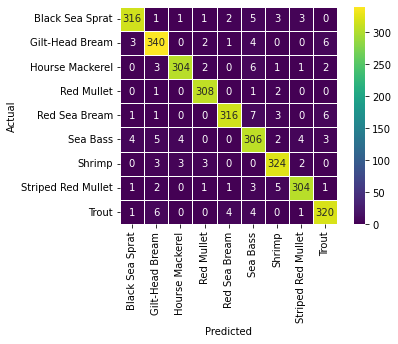

In [6]:
CNNFitted = OpenFile('CNNModel.h5')
start = time.time()
PredictedPercent = CNNFitted.predict(CNNX_test)
end = time.time()
TimeToTrain.append(["CNN","Predicting",end - start])
CNNyhat = argmax(PredictedPercent, axis=-1).astype('int')
print("CNN")

PredictedPercentTrain = CNNFitted.predict(CNNX_train)
CNNyhatTrain = argmax(PredictedPercentTrain, axis=-1).astype('int')

CNNTTrainingAccuracy = accuracy_score(CNNyhatTrain,CNNY_train_label)
CNNTTestingAccuracy = accuracy_score(CNNyhat,CNNY_test_label)
print(accuracy_score(CNNyhat,CNNY_test_label))
ConfusionMatrix(CNNY_test_label, CNNyhat,"ConfusionMatrix_CNN.png")


C:\Users\ddegroot\AppData\Local\Temp\1/ipykernel_10848/96446330.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.imshow(np.array(IncorrectlyLabeled)[fishnumber][2])
C:\Users\ddegroot\AppData\Local\Temp\1/ipykernel_10848/96446330.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.title('Actual Label - '+str(FishCategories[np.array(IncorrectlyLabeled)[fishnumber][0]])+'\n'+


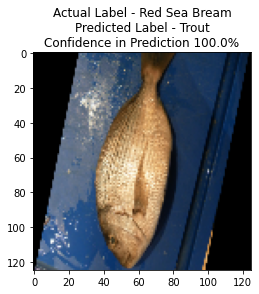

In [7]:
IncorrectlyLabeled = []
for i in range(len(CNNY_test_label)):
    if CNNY_test_label[i] != CNNyhat[i]:
        IncorrectlyLabeled.append([CNNY_test_label[i],CNNyhat[i],CNNX_test[i]])

fishnumber = 25
plt.imshow(np.array(IncorrectlyLabeled)[fishnumber][2])
plt.title('Actual Label - '+str(FishCategories[np.array(IncorrectlyLabeled)[fishnumber][0]])+'\n'+
          'Predicted Label - '+str(FishCategories[IncorrectlyLabeled[fishnumber][1]])+'\n'+
          'Confidence in Prediction ' +str(max(PredictedPercent[i]).astype('float')*100)+'%')    
plt.show()

In [9]:
c = 0
PixelColorCounts = []
StartPreProcessing = time.time()
for img in ColorImages:
    if c %500 ==0:
        print(c)
    c=c+1
    NewImage,Counts = ClassifyPixelColor(Resize(img,30,30))
    PixelColorCounts.append(Counts)
    NewImage = NewImage.astype(int)
PixelColorCounts_Df = pd.DataFrame(PixelColorCounts)
PixelColorCounts_Df.columns = ["Reds", "Oranges", "Browns", "Tans", "Blues", "LightBlues", "Grays", "Whites", "Blacks"]
XColorCounts = PixelColorCounts_Df[["Reds", "Oranges", "Browns", "Tans", "Grays","Whites"]]
EndPreProcessing = time.time()


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500


KNN
0.8946127946127946


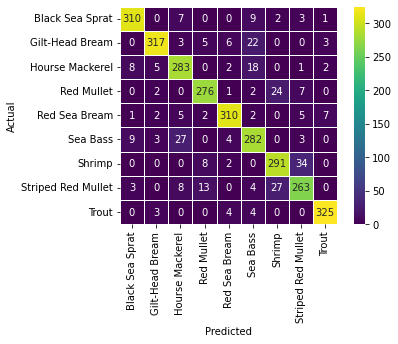

SVM
0.6380471380471381


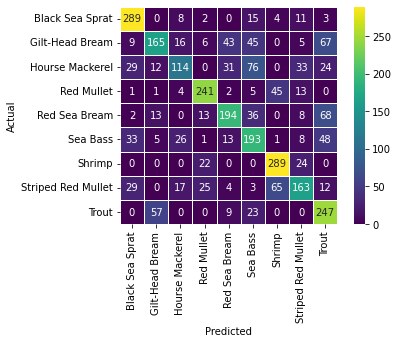

Random Forest
0.9606060606060606


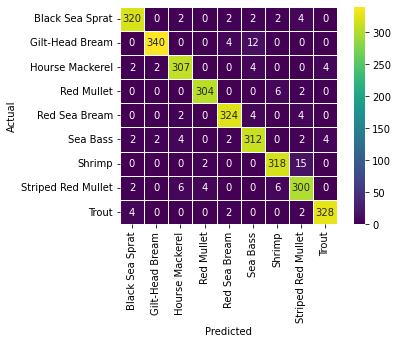

In [10]:
n = 0
index = []
for j in range(9):
    for i in range(1000):
         index.append(n)
    n = n+1
ColorDim = [index]
#ColorDimDt = pd.DataFrame(columns = ('FishPosition'))
ColorDimDt = pd.DataFrame(np.transpose(ColorDim))

#X_train, X_test, y_train, y_test = train_test_split(ColorDimDt.loc[:, ColorDimDt.columns!=0], ColorDimDt[0], test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(XColorCounts[["Reds", "Oranges", "Browns", "Tans", "Grays","Whites"]][0:9000], ColorDimDt[0], test_size=0.33, random_state=42)

y_test = np.array(y_test).astype('int')

StartTrainingKNN = time.time()
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)
KNN = KNeighborsClassifier(n_neighbors=3)
KNNFitted = KNN.fit(X_train, y_train)
EndTrainingKNN = time.time()
TimeToTrain.append(["KNN","Preprocessing and Training",(EndPreProcessing - StartPreProcessing)+ (EndTrainingKNN-StartTrainingKNN)])
joblib.dump(KNNFitted, "KNNModel.joblib")
print("KNN")
knnTrainingAccuracy = KNNFitted.score(X_train,y_train)
KnnTestedAccuracy = KNNFitted.score(X_test,y_test)
print(KNNFitted.score(X_test,y_test))

start = time.time()
KNNYhat = np.array(KNNFitted.predict(X_test)).astype('int')
end = time.time()
TimeToTrain.append(["KNN","Predicting",(end - start)])
KNNCM = ConfusionMatrix(y_test, KNNYhat,"ConfusionMatrix_KNN.png")
KNNCM

#X, y = make_classification(n_features=3, random_state=0)
SVM = SVC(random_state=0, tol=1e-5,decision_function_shape='ovr')
StartTrainingSVM = time.time()
SVMFitted = SVM.fit(X_train, y_train)
EndTrainingSVM = time.time()
TimeToTrain.append(["SVM","Preprocessing and Training",(EndPreProcessing - StartPreProcessing)+ (EndTrainingSVM-StartTrainingSVM)])
joblib.dump(SVMFitted, "SVMModel.joblib")
print("SVM")
SVMTrainingAccuracy = SVMFitted.score(X_train,y_train)
SVMTestedAccuracy = SVMFitted.score(X_test,y_test)
print(SVMFitted.score(X_test,y_test))

start = time.time()
SVMYhat = np.array(SVMFitted.predict(X_test)).astype('int')
end = time.time()
TimeToTrain.append(["SVM","Predicting",(end - start)])
SVMCM = ConfusionMatrix(y_test, SVMYhat,"ConfusionMatrix_SVM.png")
SVMCM


RF = RandomForestClassifier(n_estimators=100)
StartTrainingRF = time.time()
RFFitted = RF.fit(X_train, y_train)
EndTrainingRF = time.time()
TimeToTrain.append(["RF","Preprocessing and Training",(EndPreProcessing - StartPreProcessing)+ (EndTrainingRF-StartTrainingRF)])
joblib.dump(RFFitted, "RFModel.joblib")
print("Random Forest")
RFTrainingAccuracy = RFFitted.score(X_train,y_train)
RFTestedAccuracy = RFFitted.score(X_test,y_test)
print(RFFitted.score(X_test,y_test))

start = time.time()
RFYhat = np.array(RFFitted.predict(X_test)).astype('int')
end = time.time()
TimeToTrain.append(["RF","Predicting",(end - start)])
RFCM = ConfusionMatrix(y_test, RFYhat,"ConfusionMatrix_RF.png")
RFCM



In [11]:
TimeDataFrame = pd.DataFrame(np.array(TimeToTrain))
TimeDataFrame.columns = ["Model","TimeType","Time (Seconds)"]
TimeDataFrame
Predicting = TimeDataFrame[TimeDataFrame["TimeType"]=='Predicting']["Time (Seconds)"]
Training = TimeDataFrame[TimeDataFrame["TimeType"]=='Preprocessing and Training']["Time (Seconds)"]
TrainingAccuracy = [CNNTTrainingAccuracy, knnTrainingAccuracy, SVMTrainingAccuracy, RFTrainingAccuracy]
TestingAccuracy = [CNNTTestingAccuracy, KnnTestedAccuracy, SVMTestedAccuracy, RFTestedAccuracy]
TimeDataFrameClean = pd.DataFrame(np.transpose(np.array([['CNN',"KNN","SVM","RF"],TrainingAccuracy, TestingAccuracy, Training,Predicting])))
TimeDataFrameClean.columns = ["Model","Training Accuracy","Testing Accuracy","Preprocessing and Training (Sec)", "Predicting 2,970 Images (Sec)"]
TimeDataFrameClean

,Model,Training Accuracy,Testing Accuracy,Preprocessing and Training (Sec),"Predicting 2,970 Images (Sec)"
0,CNN,0.994859,0.955556,837.8469271659851,10.071082353591919
1,KNN,0.974295,0.894613,1309.7676832675934,0.2464597225189209
2,SVM,0.648259,0.638047,1312.717054605484,4.289699554443359
3,RF,0.999834,0.960606,1311.295053243637,0.11563730239868164


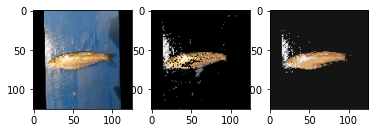

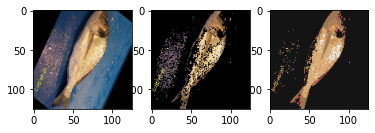

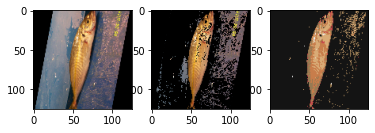

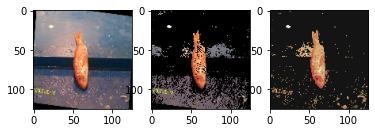

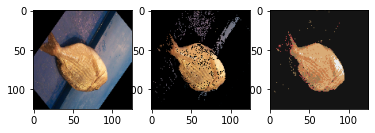

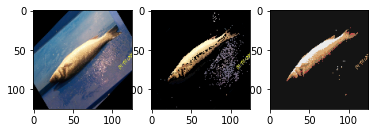

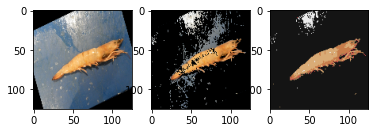

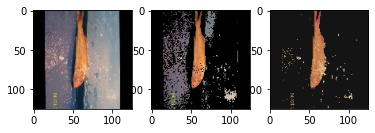

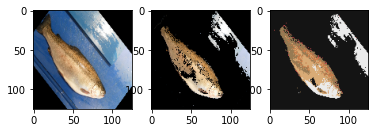

In [12]:
fishlist = [234,1948,2034,3203,4093,5932,6905,7002,8094]
PixelColorCounts = []
for i in fishlist:
    img = Resize(ColorImages[i],125,125)
    NewImage,Counts = ClassifyPixelColor((img))
    PixelColorCounts.append(Counts)
    NewImage = NewImage.astype(int)
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(img)
    axarr[1].imshow(ColorFilters(img))
    axarr[2].imshow(NewImage)        


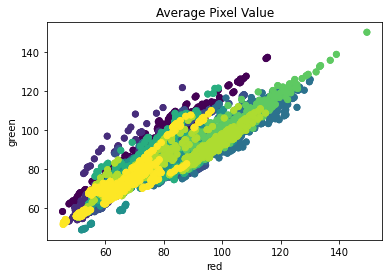

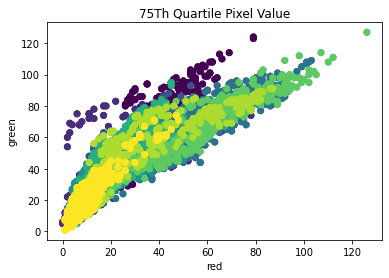

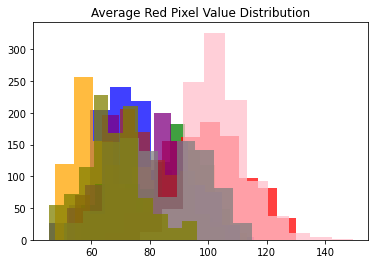

In [13]:
# Data Exploration
n = 0
Colors = ['blue','orange','green','red','purple','brown','pink','gray','olive']
index = []
for j in range(9):
    for i in range(1000):
         index.append(n)
    n = n+1
ColorDim = [index,GetColorAverage(0),GetColorAverage(1),GetColorAverage(2), GetColorQ(0,25), GetColorQ(1,25), GetColorQ(2,25),GetColorQ(0,25), GetColorQ(1,25), GetColorQ(2,25)]
ColorDimDt = pd.DataFrame(columns = ('FishPosition','RedAvg','GreenAvg','BlueAvg','Red25Q','Green25Q','Blue25Q','Red75Q','Green75Q','Blue75Q'))
ColorDimDt = pd.DataFrame(np.transpose(ColorDim))


plt.scatter(ColorDimDt[1],ColorDimDt[2],c = ColorDimDt[0])
plt.xlabel("red")
plt.ylabel("green")
plt.title("Average Pixel Value")
plt.show()

plt.scatter(ColorDimDt[4],ColorDimDt[5],c = ColorDimDt[0])
plt.xlabel("red")
plt.ylabel("green")
plt.title("75Th Quartile Pixel Value")
plt.show()

for i in range(9):
    plt.hist(ColorDimDt[ColorDimDt[0]==i][1],color = Colors[i],alpha = .75)
    plt.title("Average Red Pixel Value Distribution")
plt.show()

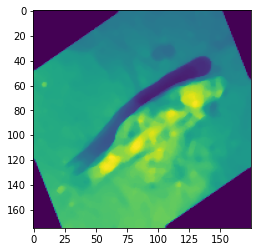

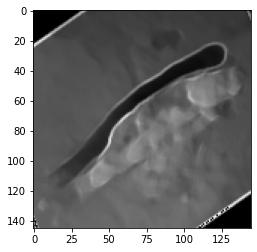

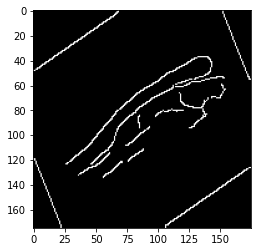

In [14]:
resize = 175
cropl = 15
croph = resize-15
Resized = GrayImage[3500]
Resized = Resize(Resized, resize,resize)
Resized = cv2.medianBlur(Resized, 5)
Resized = cv2.medianBlur(Resized, 5)


#plt.imshow(Resized,cmap='gray')
#define the vertical filter
E = [[-1,0,1], [-2,0,2], [-1,0,1]]
NE = [[0,1,2], [-1,0,1], [-2,1,0]]
N = [[1,2,1], [0,0,0], [-1,-2,-1]]
NW = [[2,1,0], [1,0,-1], [0,-1,-2]]
W = [[-1,0,1], [2,0,-2], [1,0,-1]]
SW = [[0,-1,-2], [1,0,-1],[2,-1,0]]
S = [[-1,-2,-1], [0,0,0],[1,2,1]]
SE = [[-2,-1,0], [-1,0,1],[0,1,2]]


#read in the pinwheel image
img = Resized

#get the dimensions of the image
n,m = img.shape

#initialize the edges image
edges_img = img.copy()

#loop over all pixels in the image
for row in range(3, n-2):
    for col in range(3, m-2):
        
        #create little local 3x3 box
        local_pixels = img[row-1:row+2, col-1:col+2]
        East = E*local_pixels
        West = W*local_pixels
        North = N*local_pixels
        South = S*local_pixels
        NorthEast = NE*local_pixels
        NorthWest = NW*local_pixels
        SouthEast = SE*local_pixels
        SouthWest = SW*local_pixels
        
        Escore = East.sum()/4
        Wscore = West.sum()/4
        Nscore = North.sum()/4
        Sscore = South.sum()/4        
        NEscore = NorthEast.sum()/4
        NWscore = NorthWest.sum()/4
        SEscore = SouthEast.sum()/4
        SWscore = SouthWest.sum()/4
        
        #combine the horizontal and vertical scores into a total edge score
        edge_score = (Escore**2+Wscore**2+Nscore**2+Sscore**2+ NEscore**2+ NWscore**2 +SEscore**2+SWscore**2)**.5
        
        #insert this edge score into the edges image
        edges_img[row, col] = edge_score

#remap the values in the 0-1 range in case they went out of bounds
edges_img = edges_img/edges_img.max()

plt.imshow(Resized)
plt.show()
Crop = edges_img[range(cropl,croph),:]
Crop = Crop[:,range(cropl,croph)]
plt.imshow(Crop, cmap = "gray")
plt.show()
edges = cv2.Canny(Resized,100,200)
plt.imshow(edges, cmap = 'gray')

FishNumber:6476


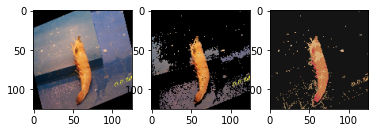

FishNumber:5317


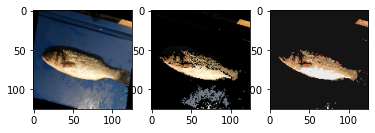

FishNumber:8966


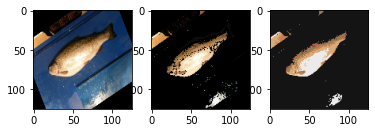

FishNumber:1180


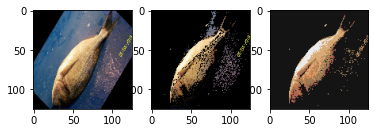

FishNumber:1057


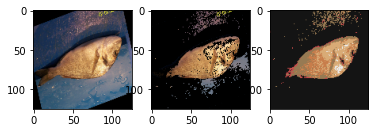

FishNumber:5213


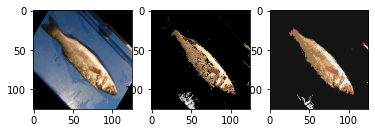

FishNumber:2164


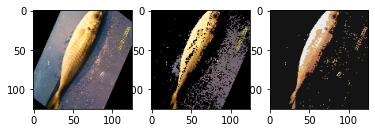

FishNumber:8519


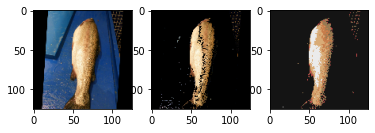

FishNumber:6489


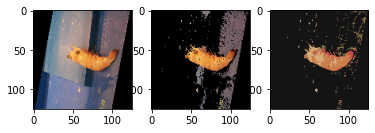

FishNumber:5952


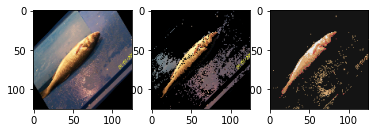

In [37]:
PixelColorCounts = []
for i in range(10):
    c = IncorrectRF.index[i]
    img = Resize(ColorImages[c],125,125)
    NewImage,Counts = ClassifyPixelColor((img))
    PixelColorCounts.append(Counts)
    print("FishNumber:" + str(c))
    NewImage = NewImage.astype(int)
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(img)
    axarr[1].imshow(ColorFilters(img))
    axarr[2].imshow(NewImage) 
    plt.show()
